<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Pregunta 1 - Redes Recurrentes </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Diseño e implementación de Redes Neuronales Recurrentes (RNN).
* Regularización en Redes Recurrentes.

<hr style="height:2px;border:none"/>

<a id="primero"></a>
## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />

Primero, cargamos todas las dependencias necesarias, y cargamos el archivo con los datos que usaremos en esta actividad.

In [2]:
# %load_ext autoreload
# %autoreload
import collections
import random
import sys

from keras import activations
from keras import callbacks
from keras import layers
from keras import losses
from keras import models
from keras.preprocessing import sequence
from keras import optimizers
from keras import utils
from matplotlib import pyplot
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn import model_selection

Using TensorFlow backend.


In [3]:
#local_file_name = 'ner.csv'
# If running locally, uncomment following line:
#local_file_name = '/home/on1link/Descargas/ner.csv'
local_file_name = '/home/cserpell/datasets/ner.csv'
df_ner = pd.read_csv(local_file_name, encoding ='cp1252', error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


Veamos cómo es la estructura leida:

In [4]:
print('Tamaño del dataframe: ', df_ner.shape)
print('Columnas: ', df_ner.columns.values)
print('Ejemplo: ', df_ner.loc[10,])
df_ner.describe()

Tamaño del dataframe:  (1050794, 25)
Columnas:  ['Unnamed: 0' 'lemma' 'next-lemma' 'next-next-lemma' 'next-next-pos'
 'next-next-shape' 'next-next-word' 'next-pos' 'next-shape' 'next-word'
 'pos' 'prev-iob' 'prev-lemma' 'prev-pos' 'prev-prev-iob'
 'prev-prev-lemma' 'prev-prev-pos' 'prev-prev-shape' 'prev-prev-word'
 'prev-shape' 'prev-word' 'sentence_idx' 'shape' 'word' 'tag']
Ejemplo:  Unnamed: 0                  10
lemma                      war
next-lemma                  in
next-next-lemma           iraq
next-next-pos              NNP
next-next-shape    capitalized
next-next-word            Iraq
next-pos                    IN
next-shape           lowercase
next-word                   in
pos                         NN
prev-iob                     O
prev-lemma                 the
prev-pos                    DT
prev-prev-iob                O
prev-prev-lemma        protest
prev-prev-pos               VB
prev-prev-shape      lowercase
prev-prev-word         protest
prev-shape           

Unnamed: 0  sentence_idx
count  1.050794e+06  1.050794e+06
mean   4.153109e+05  1.898184e+04
std    3.447836e+05  1.576237e+04
min    0.000000e+00  1.000000e+00
25%    1.313490e+05  5.997000e+03
50%    2.626980e+05  1.201700e+04
75%    7.858758e+05  3.592600e+04
max    1.048574e+06  4.795900e+04

El dataframe contiene más de un millón de filas, con 25 columnas, cuyos encabezados son los expuestos. Vemos que en cada fila, se indica una palabra central que está siendo clasificada. En el ejemplo, es la palabra `war`. Se indica la palabra siguiente y subsiguiente, y la anterior y la anterior a la anterior. Además, para cada una de las palabras, se indica una serie de características, tal como  la "forma" (`shape`), que indica si es mayúscula o minúscula, "parte de la oración" (`pos`), que indica la función dentro de la oración, `iob`(que no sé lo que es), y  una versión `lemma` donde se guarda solo la raíz de la palabra, sin plurales, conjugaciones, géneros, etc.

In [5]:
print('Posibles valores para "pos"', df_ner.loc[:, 'pos'].unique())
print('Posibles valores para "shape"', df_ner.loc[:, 'shape'].unique())
print('Posibles valores para "tag"', df_ner.loc[:, 'tag'].unique())
print('Posibles valores para "prev-iob"', df_ner.loc[:, 'prev-iob'].unique())

Posibles valores para "pos" ['NNS' 'IN' 'VBP' 'VBN' 'NNP' 'TO' 'VB' 'DT' 'NN' 'CC' 'JJ' '.' 'VBD' 'WP'
 '``' 'CD' 'PRP' 'VBZ' 'POS' 'VBG' 'RB' ',' 'WRB' 'PRP$' 'MD' 'WDT' 'JJR'
 ':' 'JJS' 'WP$' 'RP' 'PDT' 'NNPS' 'EX' 'RBS' 'LRB' 'RRB' '$' 'RBR' ';'
 'UH']
Posibles valores para "shape" ['capitalized' 'lowercase' 'punct' 'number' 'other' 'contains-hyphen'
 'uppercase' 'abbreviation' 'ending-dot' 'camelcase' 'mixedcase']
Posibles valores para "tag" ['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']
Posibles valores para "prev-iob" ['__START1__' 'O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim'
 'B-art' 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


Vemos entonces que hay diversas etiquetas para `pos` y `shape`. En el caso de las etiquetas `tag`, se presentan etiquetas START o END del inicio o fin de la frase, junto con:
- `O`, indicando nada especial.
- `B-`, indicando un lugar, persona, cosa, etc.
- `I-`, indicando continuación del nombre de un lugar, persona, cosa, etc.

Las tres letras que acompañan a `B` o `I` indican el tipo de objeto (geográfico, gentilicio, etc.). Para ver mejor cómo funcionan estas etiquetas, veamos algunos ejemplos:

In [6]:
print('Ejemplos B-geo', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-geo', 'word'].head().values)
print('Ejemplos B-gpe', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-gpe', 'word'].head().values)
print('Ejemplos B-per', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-per', 'word'].head().values)
print('Ejemplos B-org', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-org', 'word'].head().values)
print('Ejemplos B-tim', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-tim', 'word'].head().values)
print('Ejemplos B-art', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-art', 'word'].head().values)
print('Ejemplos B-nat', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-nat', 'word'].head().values)
print('Ejemplos B-eve', df_ner.loc[df_ner.loc[:, 'tag'] == 'B-eve', 'word'].head().values)
print('Ejemplos I-geo', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-geo', 'word'].head().values)
print('Ejemplos I-gpe', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-gpe', 'word'].head().values)
print('Ejemplos I-per', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-per', 'word'].head().values)
print('Ejemplos I-org', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-org', 'word'].head().values)
print('Ejemplos I-tim', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-tim', 'word'].head().values)
print('Ejemplos I-art', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-art', 'word'].head().values)
print('Ejemplos I-nat', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-nat', 'word'].head().values)
print('Ejemplos I-eve', df_ner.loc[df_ner.loc[:, 'tag'] == 'I-eve', 'word'].head().values)

Ejemplos B-geo ['London' 'Iraq' 'Hyde' 'Britain' 'Brighton']
Ejemplos B-gpe ['British' 'English' 'Britain' 'British' 'Iran']
Ejemplos B-per ['Bush' 'President' 'Thomas' 'President' 'Prophet']
Ejemplos B-org ['Labor' 'International' 'IAEA' 'European' 'U.N.']
Ejemplos B-tim ['Wednesday' 'Wednesday' 'Tuesday' 'Wednesday' 'Wednesday']
Ejemplos B-art ['Nuclear' 'Saltillo' 'Pentastar' 'Chrysler' 'Dodge']
Ejemplos B-nat ['H5N1' 'H5N1' 'Jing' 'Jing' 'H5N1']
Ejemplos B-eve ['2012' 'Games' 'Games' '2008' 'Operation']
Ejemplos I-geo ['Park' 'State' 'State' 'Delta' 'Arab']
Ejemplos I-gpe ['States' 'Korea' 'Binh' 'Ababa' 'City']
Ejemplos I-per ['Mahmoud' 'Ahmadinejad' 'Horbach' 'Abdullahi' 'Yusuf']
Ejemplos I-org ['Party' 'Atomic' 'Energy' 'Agency' 'Union']
Ejemplos I-tim ['8' '1' '2' '3' 'of']
Ejemplos I-art ['Non-Proliferation' 'V-6' 'Simple' 'Life' 'Morning']
Ejemplos I-nat ['Jing' 'Jing' 'Acute' 'Respiratory' 'Syndrome']
Ejemplos I-eve ['Summer' 'Olympics' 'Olympic' 'Medusa' 'War']


Finalmente, veamos cuántas veces aparece cada una de estas etiquetas:

O        889973
B-geo     37525
B-tim     20193
B-org     20184
I-per     17382
B-per     17011
I-org     16537
B-gpe     16392
I-geo      7409
I-tim      6298
B-art       434
B-eve       348
I-eve       297
I-art       280
I-gpe       229
B-nat       226
I-nat        76
Name: tag, dtype: int64


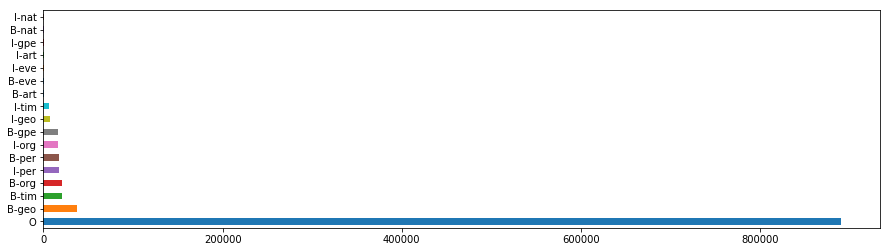

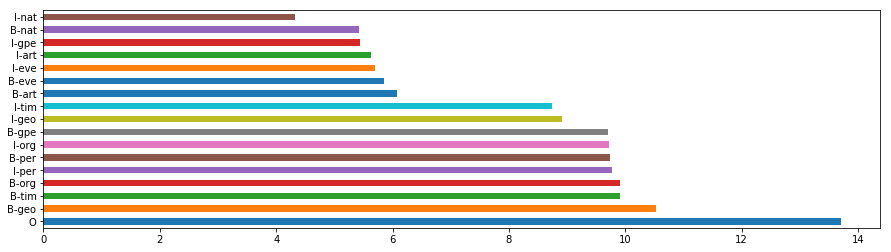

In [25]:
count_tags = df_ner.loc[:, 'tag'].value_counts()
print(count_tags)
_ = count_tags.plot(kind='barh', figsize=(15, 4))
pyplot.show()
_ = np.log(count_tags).plot(kind='barh', figsize=(15, 4))
pyplot.show()

Podemos ver que las clases son bastante poco balanceadas, con la clase `O` preponderando, luego otras en el orden de decenas de miles, y luego otras en cientos.

> a) En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**

Aquí resaltamos que solo seleccionamos las características de la palabra actual, ya que procesaremos los datos como una secuencia. Es decir, en cada paso el modelo procesará una palabra. En relación al uso de lemma o word, lemma tiene la gracia de que varias palabras relacionadas quedan caracterizadas por el mismo lemma. Esto es debido a que morfológicamente es la forma más simple, de la cual otras formas puede ser derivadas.

In [26]:
dataset = df_ner.loc[:, ['lemma', 'word', 'pos', 'tag', 'prev-iob']]

Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá las etiquetas (*tags*), esto es un arreglo de arreglos de *lemmas* y un arreglo de arreglos de *tags* respectivamente. **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**

In [27]:
dataX, dataY = [], []
lemmas, labels = set(), set()  # uniques
sentence = []
labels_sentence = []
for index, fila in dataset.iterrows():
    if fila['prev-iob'] == '__START1__': 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence = []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila['lemma'])  # add lemma
    labels_sentence.append(fila['tag'])  # TAG
dataX = np.asarray(dataX[1:])  # data to  array
dataY = np.asarray(dataY[1:])

Esta estructura contiene una lista de secuencias de lemmas, en X, y una lista de secuencias de etiquetas, en Y. El largo de cada secuencia es variable, ya que distintas frases tienen distinto largo. Obviamente, el largo de cada secuencia en X tiene el mismo largo que la secuencia asociada en Y, ya que cada palabra o lemma tiene una etiqueta asociada. Lo confirmamos a continuación, donde vemos que tenemos poco más de 48 mil secuencias.

In [28]:
print('Largo de dataX:', len(dataX))
print('Largo de dataY:', len(dataY))
print('Largo de dataX[0]:', len(dataX[0]))
print('Largo de dataY[0]:', len(dataY[0]))
print('Largo de dataX[1]:', len(dataX[1]))
print('Largo de dataY[1]:', len(dataY[1]))

Largo de dataX: 48081
Largo de dataY: 48081
Largo de dataX[0]: 24
Largo de dataY[0]: 24
Largo de dataX[1]: 30
Largo de dataY[1]: 30


> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

Histograma de largo de secuencias


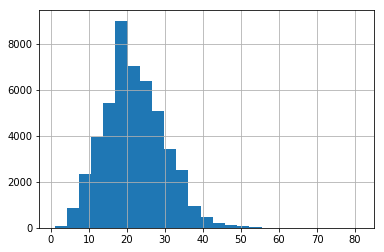

Media: 21.854495538778313
La más larga: 81
La más corta: 1


In [11]:
largos = pd.Series([len(seq) for seq in dataX])
print('Histograma de largo de secuencias')
_ = largos.hist(bins=25)
pyplot.show()
print('Media:', largos.mean())
print('La más larga:', largos.max())
print('La más corta:', largos.min())

Podemos ver que el largo de las secuencias varía, en torno a una media de 21,9. La más larga tiene largo 81 y la más corta, solo una palabra. Veamos la frecuencia de las palabras.

Total de palabras: 20243
Media de apariciones de cada palabra: 51.90861038383639


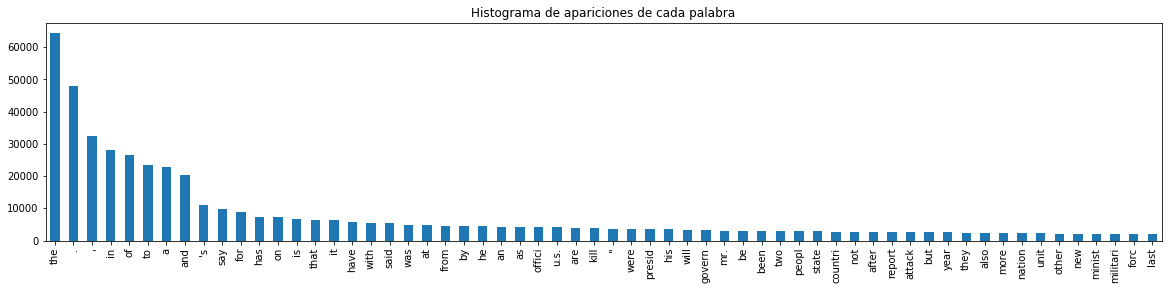

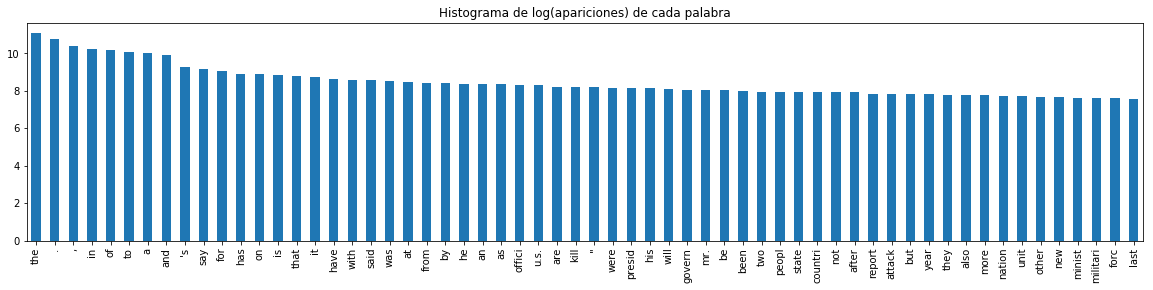

In [12]:
all_words = []
for one in dataX:
    all_words.extend(list(one))
word_counts = collections.Counter(all_words)
wc_df = pd.DataFrame.from_dict(word_counts, orient='index').sort_values(
    0, ascending=False)
print('Total de palabras:', len(wc_df))
print('Media de apariciones de cada palabra:', wc_df.iloc[:, 0].mean())
_ = wc_df.head(n=60).plot.bar(
    figsize=(20, 4), legend=False,
    title='Histograma de apariciones de cada palabra')
pyplot.show()
_ = np.log(wc_df.head(n=60)).plot.bar(
    figsize=(20, 4), legend=False,
    title='Histograma de log(apariciones) de cada palabra')

Vemos entonces que las palabras y símbolos en inglés más comunes, tales como `the`, `.`, `,`, `in`, `of`, `to`, `a`, `and` son, como se espera, las que más aparecen en todas las secuencias. Además, vemos que la cantidad de palabras diferentes (en este caso lemmas), es de poco más de 20 mil, y que el promedio de apariciones de cada una es 52. Al ver los gráficos expuestos con las 60 palabras más comunes, vemos que aun está muy lejos de la media de 52 apariciones, por lo que significa que hay una cola muy larga de palabras con relativamente pocas apariciones.

Para ver si cumple con una ley Zipf, veamos un gráfico log-log de la cantidad de apariciones de cada palabra:

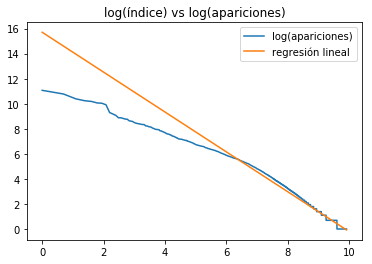

In [13]:
to_plot = pd.DataFrame(
    data={'x': [np.log(pos + 1) for pos in range(len(wc_df))],
          'y': np.log(wc_df.iloc[:, 0])})
slope, intercept, r_value, p_value, std_err = stats.linregress(
    to_plot.loc[:, 'x'], to_plot.loc[:, 'y'])
_ = pyplot.plot(to_plot.loc[:, 'x'], to_plot.loc[:, 'y'], marker='',
                label='log(apariciones)')
_ = pyplot.plot(to_plot.loc[:, 'x'], slope * to_plot.loc[:, 'x'] + intercept,
                marker='', label='regresión lineal')
_ = pyplot.title('log(índice) vs log(apariciones)')
_ = pyplot.legend()

Podemos ver que si bien la recta de ajuste no pasa totalmente por la línea azul, sí pasa por la mayoría de las palabras, que se encuentra en la mitad derecha del gráfico. Esto es debido a que estamos viendo log(índice), y no el índice original, por lo que la mayoría de las palabras está al lado derecho del gráfico. Es decir, para las palabras más comunes (izquierda del gráfico), la ley Zipf no se cumple, pero para la mayoría, sí.

Finalmente, veamos cómo se distribuyen las palabras en las etiquetas:

In [14]:
words_per_label = {}
for label in dataset['tag'].unique():
    the_words = []
    for index, fila in dataset.iterrows():
        if fila['tag'] == label:
            the_words.append(fila['lemma'])
    words_per_label[label] = the_words

Total de palabras clase O : 12131
Media de apariciones de cada palabra en clase O : 73.36353144835546


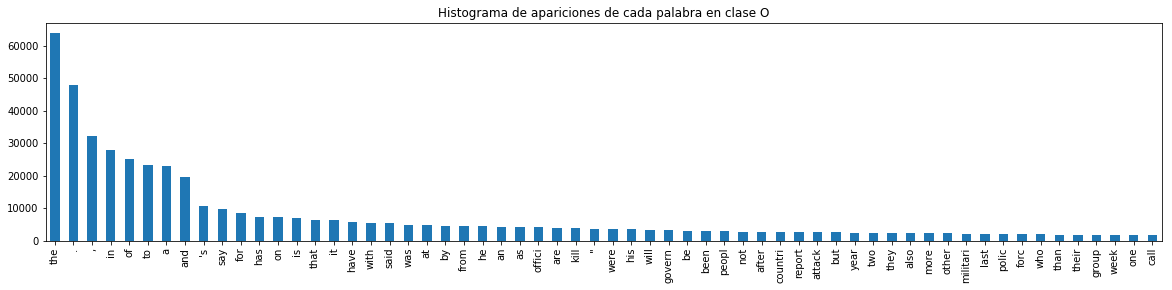

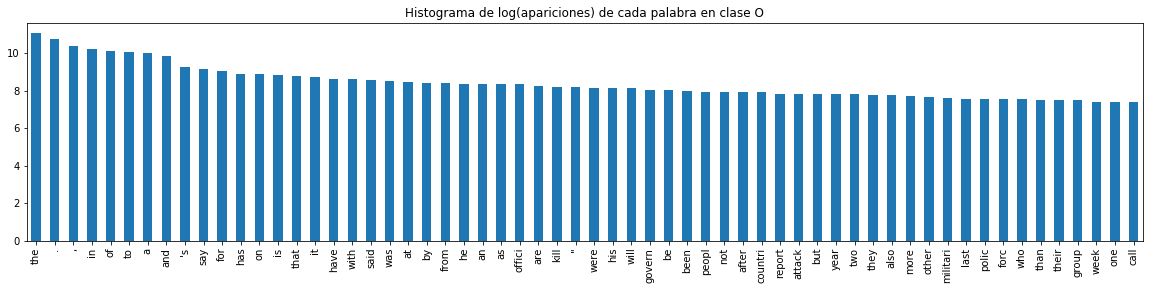

Total de palabras clase B-geo : 2478
Media de apariciones de cada palabra en clase B-geo : 15.143260694108152


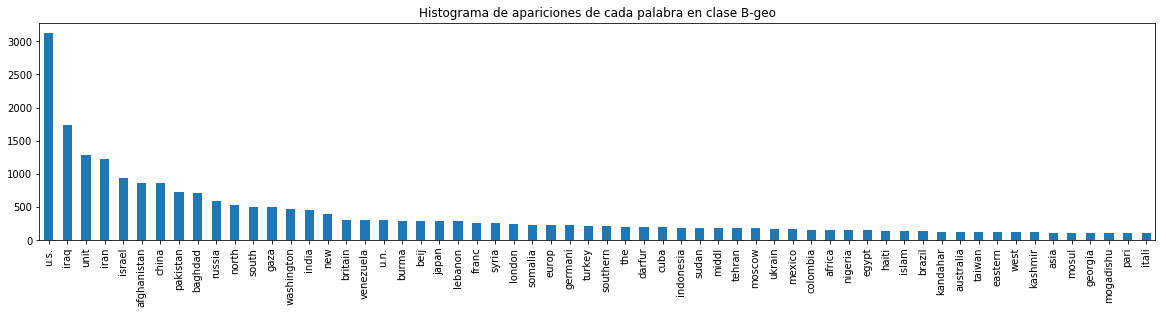

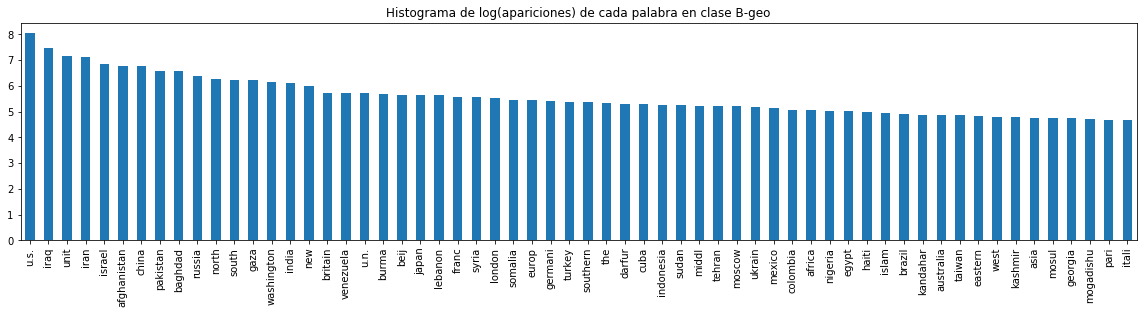

Total de palabras clase B-gpe : 335
Media de apariciones de cada palabra en clase B-gpe : 48.93134328358209


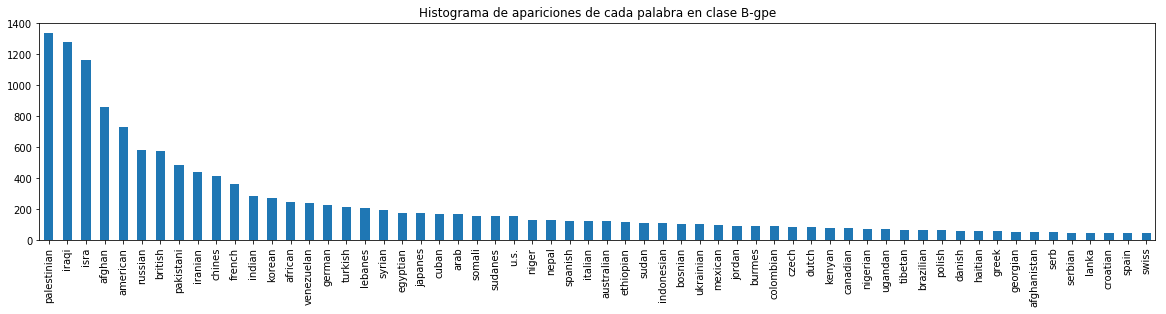

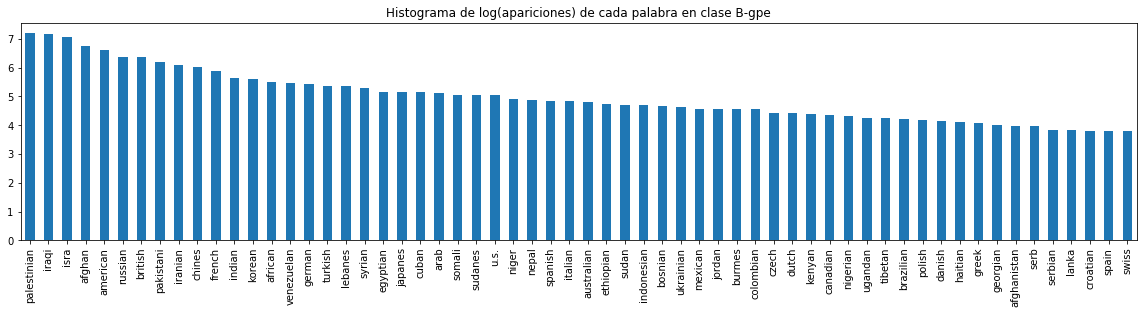

Total de palabras clase B-per : 2372
Media de apariciones de cada palabra en clase B-per : 7.171585160202361


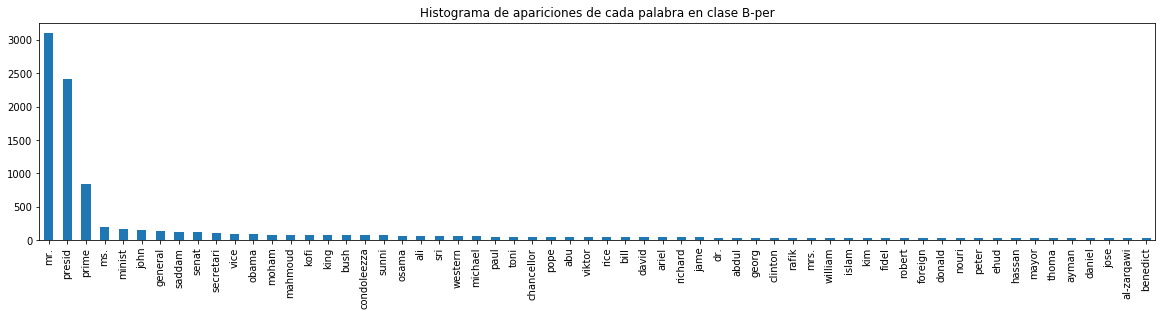

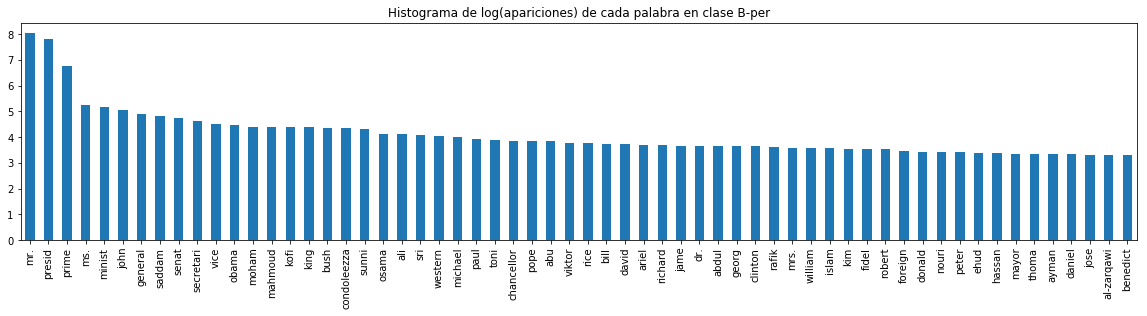

Total de palabras clase I-geo : 832
Media de apariciones de cada palabra en clase I-geo : 8.905048076923077


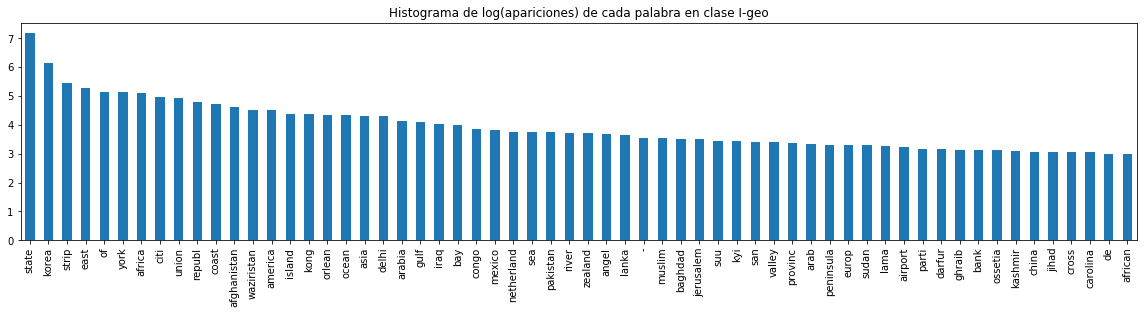

Total de palabras clase B-org : 2328
Media de apariciones de cada palabra en clase B-org : 8.670103092783505


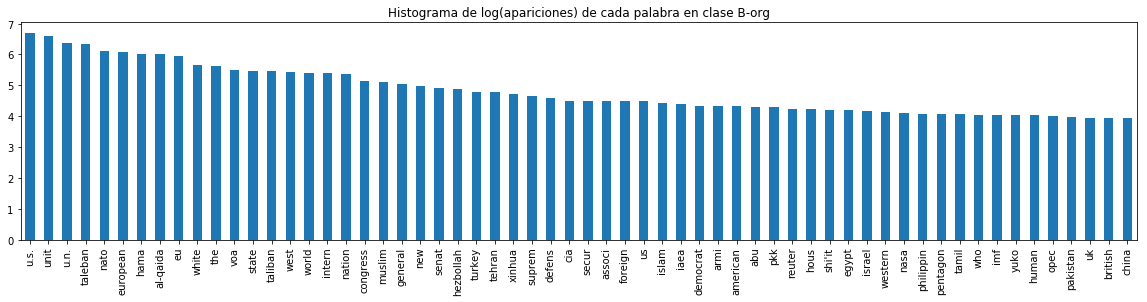

Total de palabras clase I-org : 2276
Media de apariciones de cada palabra en clase I-org : 7.265817223198594


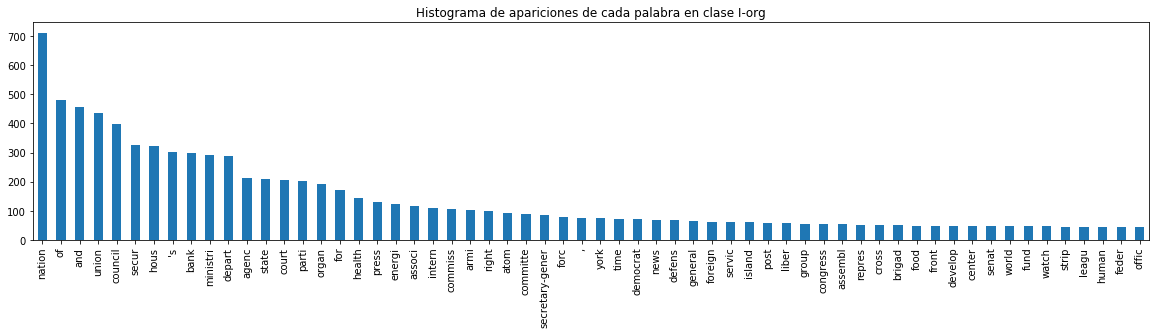

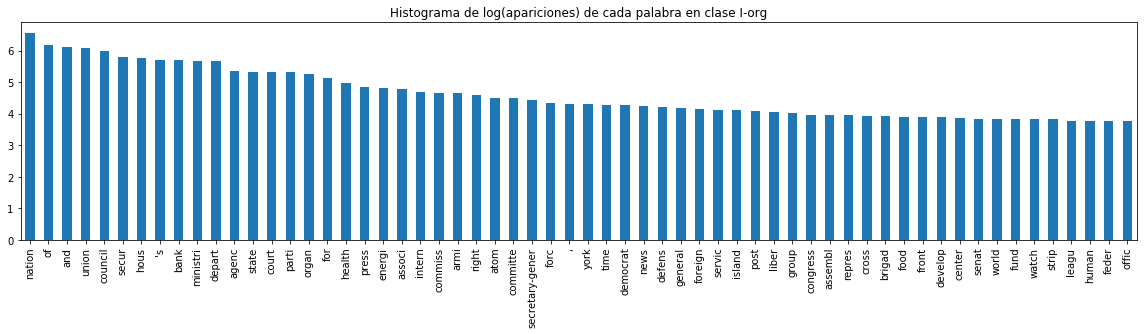

Total de palabras clase B-tim : 875
Media de apariciones de cada palabra en clase B-tim : 23.077714285714286


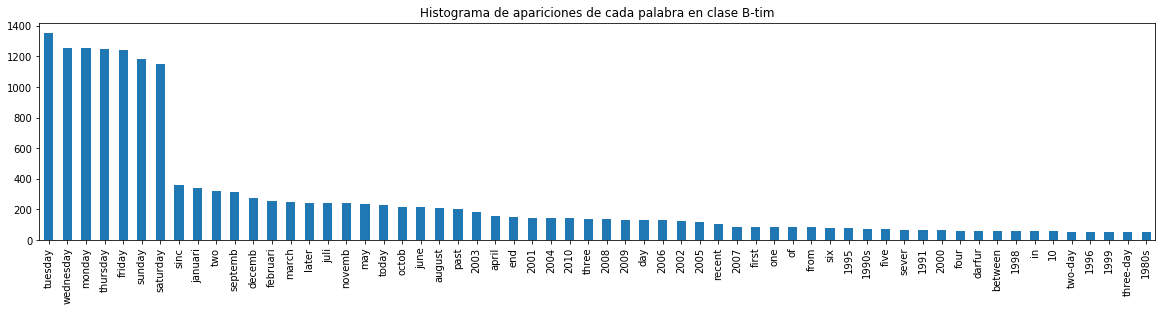

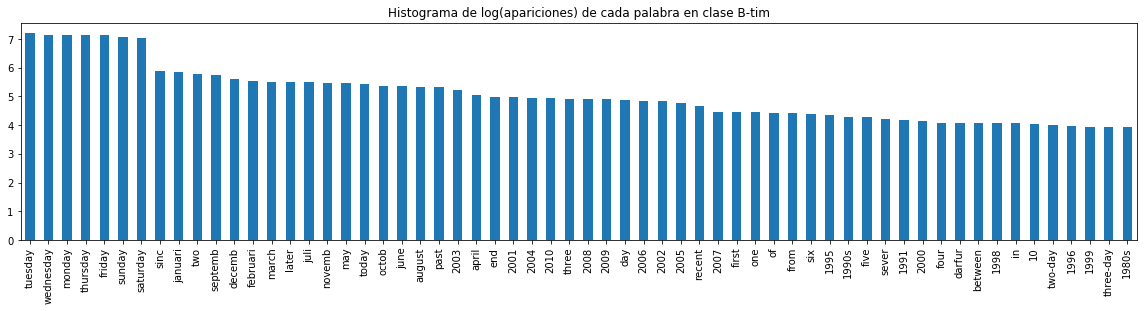

Total de palabras clase B-art : 205
Media de apariciones de cada palabra en clase B-art : 2.1170731707317074


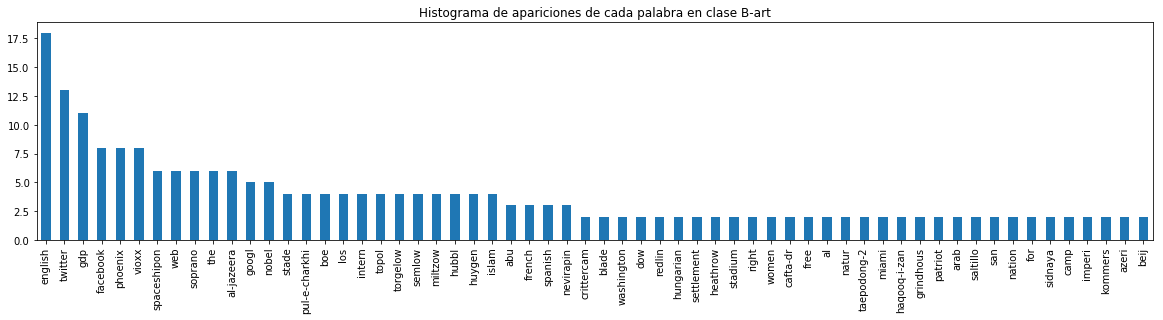

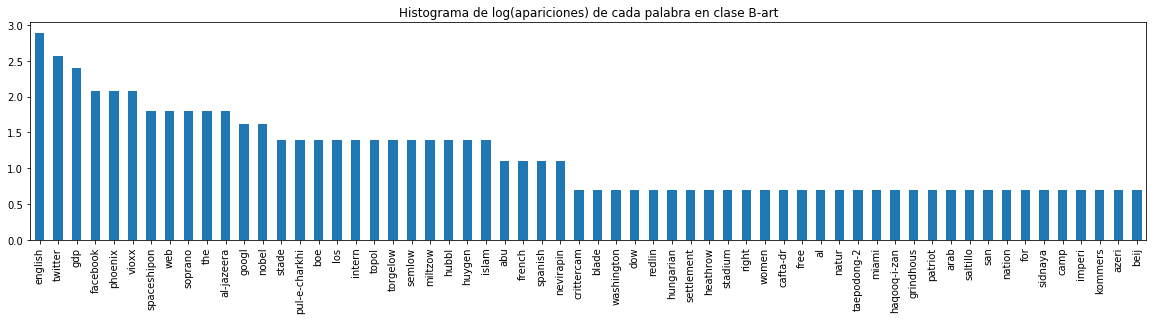

Total de palabras clase I-art : 153
Media de apariciones de cada palabra en clase I-art : 1.8300653594771241


Total de palabras clase I-per : 3168
Media de apariciones de cada palabra en clase I-per : 5.486742424242424


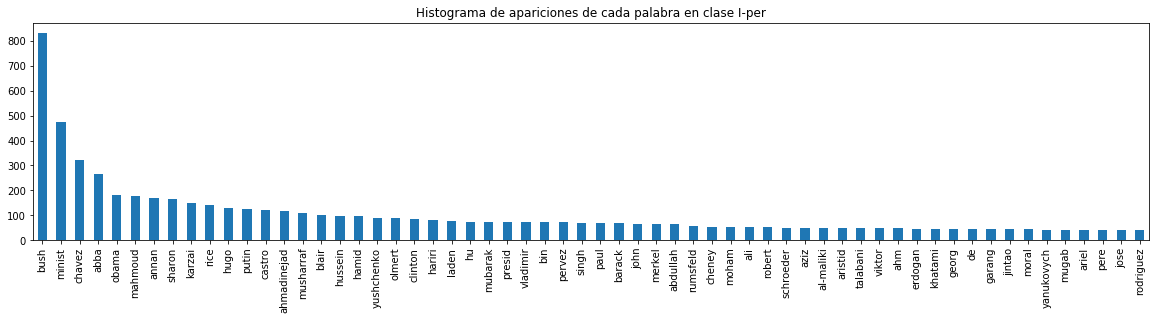

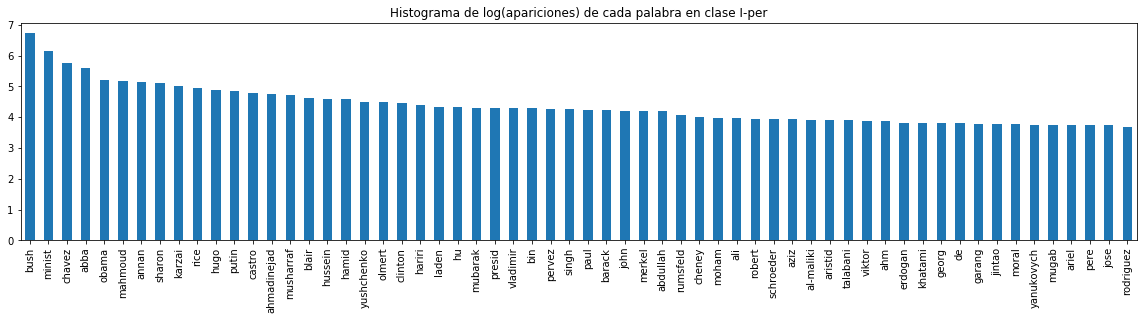

Total de palabras clase I-gpe : 35
Media de apariciones de cada palabra en clase I-gpe : 6.542857142857143


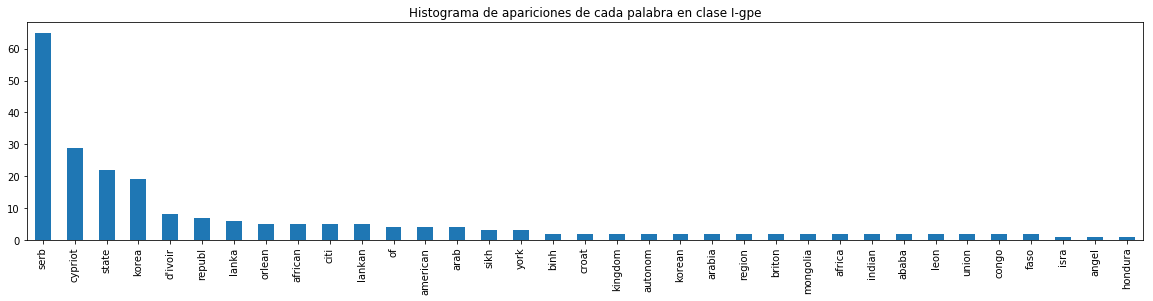

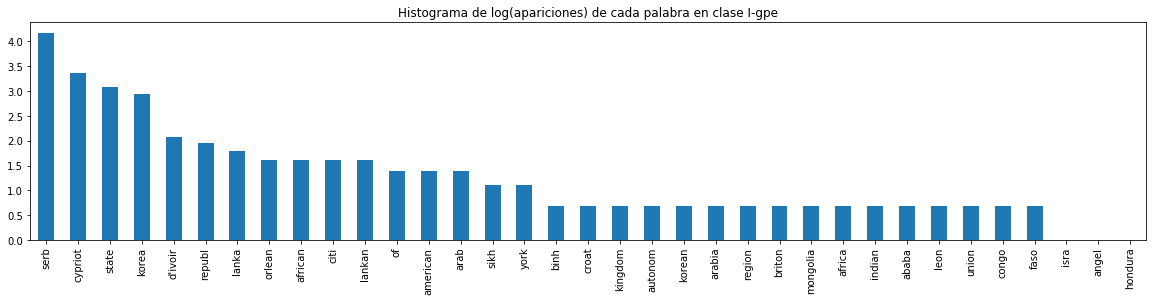

Total de palabras clase I-tim : 546
Media de apariciones de cada palabra en clase I-tim : 11.534798534798535


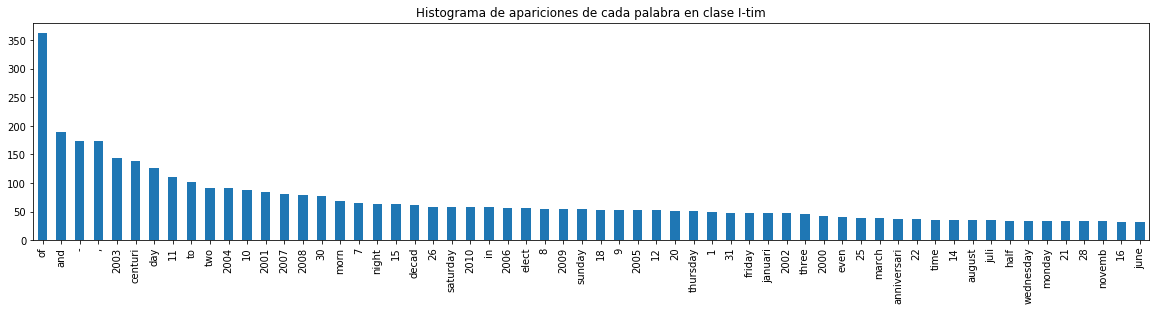

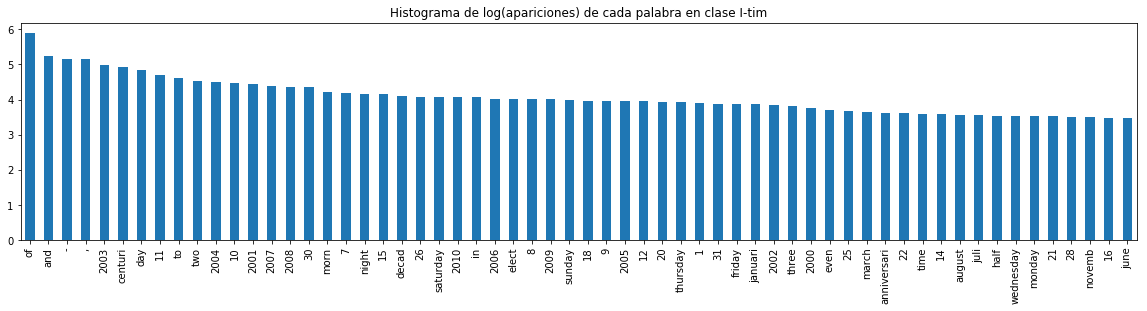

Total de palabras clase B-nat : 32
Media de apariciones de cada palabra en clase B-nat : 7.0625


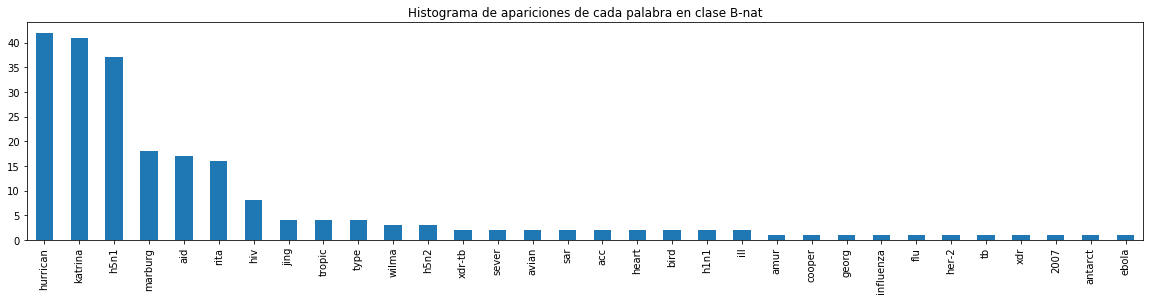

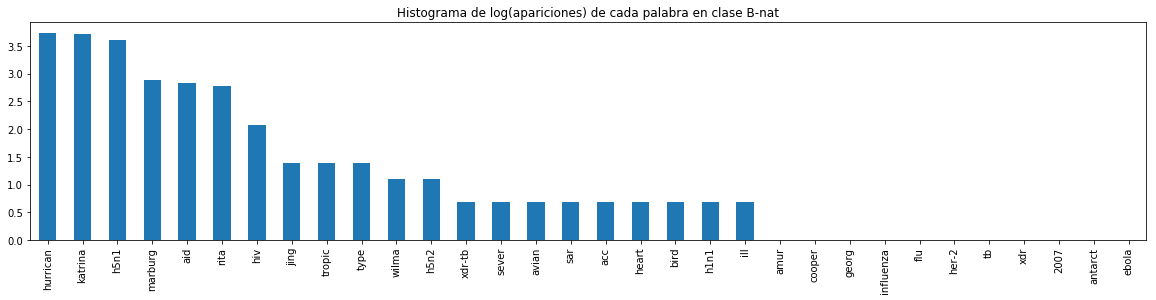

Total de palabras clase B-eve : 82
Media de apariciones de cada palabra en clase B-eve : 4.2439024390243905


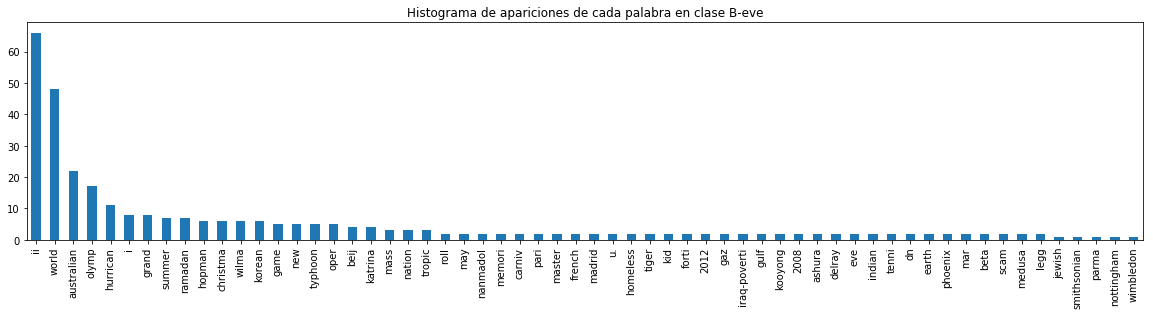

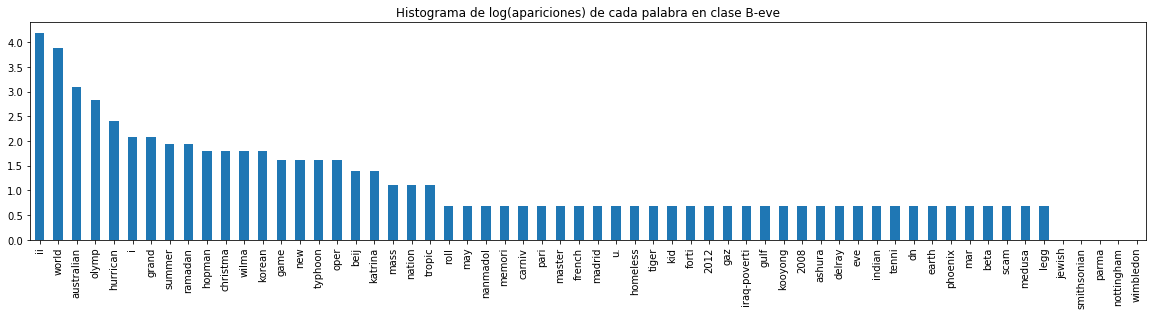

Total de palabras clase I-eve : 66
Media de apariciones de cada palabra en clase I-eve : 4.5


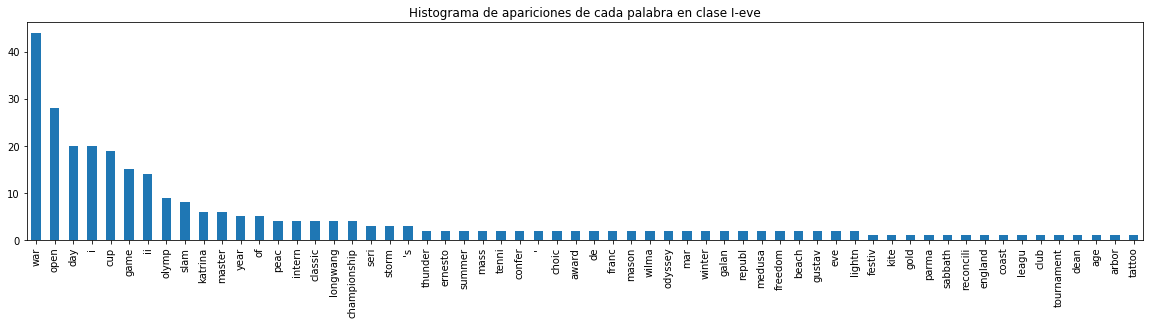

Total de palabras clase I-nat : 16
Media de apariciones de cada palabra en clase I-nat : 4.75


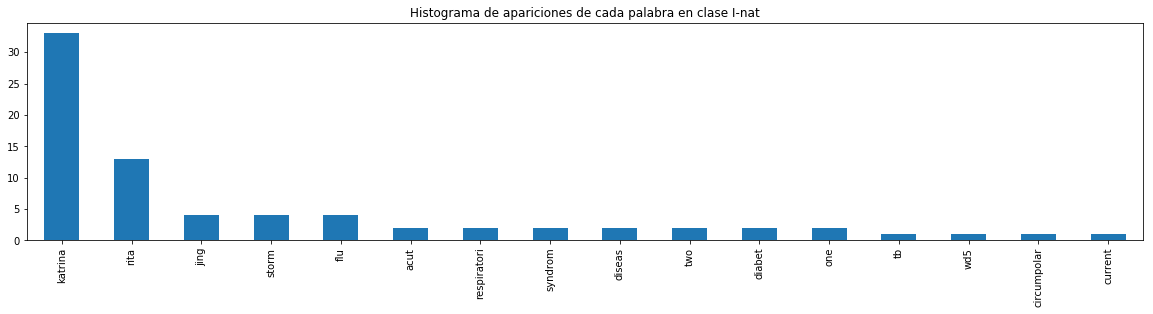

In [15]:
for label in dataset['tag'].unique():
    word_counts = collections.Counter(words_per_label[label])
    wc_df = pd.DataFrame.from_dict(word_counts, orient='index').sort_values(
        0, ascending=False)
    print('Total de palabras clase', label, ':', len(wc_df))
    print('Media de apariciones de cada palabra en clase', label, ':',
          wc_df.iloc[:, 0].mean())
    _ = wc_df.head(n=60).plot.bar(
        figsize=(20, 4), legend=False,
        title='Histograma de apariciones de cada palabra en clase {}'.format(label))
    pyplot.show()
    _ = np.log(wc_df.head(n=60)).plot.bar(
        figsize=(20, 4), legend=False,
        title='Histograma de log(apariciones) de cada palabra en clase {}'.format(label))
    pyplot.show()

A través de esta serie de gráficos, vemos que cada clase queda bastante definida por el tipo de palabras que incluye, y que en cada clase hay algunas pocas palabras que dominan, probablemente por la cantidad de frases que las nombran en este conjunto particular de datos.

> c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo que será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. **Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas**. Además de esto, debido al largo distinto de las sentencias se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*0, 0*].

Primero creamos la lista de posibles lemmas y la lista de posibles etiquetas. Luego, un diccionario para pasar de la palabra a la codificación en números, y otro para pasar de la etiqueta a la codificación numérica creada. Finalmente, transformamos los datos originales en string a secuencias de números enteros que codifican las palabras y etiquetas.

In [29]:
# add fullfill lemma and tag to the dictionary
lemmas = set()
labels = set()
for index, fila in dataset.iterrows():
    lemmas.add(fila['lemma'])
    labels.add(fila['tag'])
lemmas = list(lemmas)
labels = list(labels)
lemma2idx = {w: i for i, w in enumerate(lemmas, start=1)}  # Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels, start=1)}
dataXf = [[lemma2idx[lemma] for lemma in sentence] for sentence in dataX]
dataYf = [[lab2idx[ner] for ner in ner_tags] for ner_tags in dataY]

Como las secuencias pueden tener distinto largo, creamos una etiqueta y palabra adicional para indicar cuando la secuencia ya se ha acabado, con la que haremos *padding*.

In [30]:
max_input_length = 0
for one in dataXf:
    if len(one) > max_input_length:
        max_input_length = len(one)
lemma2idx['ENDSENTENCE'] = 0
lab2idx['ENDTAG'] = 0
n_lemmas = len(lemma2idx)
n_labels = len(lab2idx)

> d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece más conveniente al rellenar con un valor especial respecto al cómo funciona una red recurrente y cómo funciona su memoria **¿Al principio o al final de la sentencia?** Comente

Realizamos un `padding` al final de la secuencia, de manera que todas tengan el mismo largo, pero que todas comiencen en el mismo lugar (la primera palabra de la secuencia es una palabra válida, y podría terminar en símbolo especial). Lo hacemos así, pues en la mayoría de los experimentos realizados abajo, se utiliza una red recurrente unidireccional, que comienza a procesar la secuencia desde el principio. La red así aprenderá a etiquetar las palabras, hasta la etiqueta especial, donde ya no nos interesa seguir etiquetando realmente.

In [31]:
X = sequence.pad_sequences(dataXf, maxlen=max_input_length, padding='post',
                           value=lemma2idx['ENDSENTENCE'])
y = sequence.pad_sequences(dataYf, maxlen=max_input_length, padding='post',
                           value=lab2idx['ENDTAG'])

Ahora tenemos matrices de entrada con un largo fijo:

In [32]:
print('Tamaño de X:', X.shape)
print('Tamaño de y:', y.shape)

Tamaño de X: (48081, 81)
Tamaño de y: (48081, 81)


> e) Para poder entregar una clasificación sobre los distintos *tags* es necesario tranformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [34]:
y_one_hot = np.asarray([utils.to_categorical(i, num_classes=n_labels) for i in y])
# X_one_hot = np.asarray([utils.to_categorical(i, num_classes=n_lemmas) for i in X])
# test tiene 20% de los datos
# val tiene 20% * 80% = 16% de los datos
# train tiene 80% * 80% = 64% de los datos
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(
    X, y_one_hot, test_size=0.2)  # , random_state=22)
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train_val, y_train_val, test_size=0.2)
print('Tamaño X train:', X_train.shape, 'y train:', y_train.shape)
print('Tamaño X val:', X_val.shape, 'y val:', y_val.shape)
print('Tamaño X test:', X_test.shape, 'y test:', y_test.shape)

Tamaño X train: (30771, 81) y train: (30771, 81, 18)
Tamaño X val: (7693, 81) y val: (7693, 81, 18)
Tamaño X test: (9617, 81) y test: (9617, 81, 18)


Como vemos, transformamos las matrices originales de ancho 81, en tensores de tres dimensiones, donde cada una de las 81 etiquetas, es codificada por un vector *one hot*, de largo 18. El largo 18 viene dado por la cantidad posible de etiquetas. Podemos notar que no transformamos las entradas X, pues ésta seguirá estando codificada por un número entero, y no por un vector *one hot*.

> f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

Primero construimos una función auxiliar que itilizaremos en todos los experimentos más abajo, con las opciones que necesitaremos.

In [36]:
EPOCHS = 20

def build_model(embedding_vector, dropout_in=-1.0, dropout_out=-1.0,
                bidirectional=None, use_mask_zero=False, use_gru=False,
                recurrent_nodes=100):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=n_lemmas,
                               output_dim=embedding_vector,
                               input_length=max_input_length,
                               mask_zero=use_mask_zero))
    if dropout_in > 0.0:
        model.add(layers.Dropout(dropout_in))
    recurrent_layer = layers.GRU if use_gru else layers.LSTM
    layer_lstm = recurrent_layer(units=recurrent_nodes, return_sequences=True)
    if bidirectional is None:
        model.add(layer_lstm)
    else:
        model.add(layers.Bidirectional(layer_lstm, merge_mode=bidirectional))
    if dropout_out > 0.0:
        model.add(layers.Dropout(dropout_out))
    model.add(layers.Dense(n_labels, activation=activations.softmax))
    model.summary()
    model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam())
    hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS,
                     batch_size=128)
    return hist, model

En este caso, creamos una red con una capa de embedding de tamaño 32 y 100 nodos en la capa recurrente. Esto significa que la entrada, pasa de la codificación entera, a una codificación en 32 dimensiones. Esto permite a la red aprender características que se derivan de las palabras, y que luego son usadas por la red recurrente para realizar la tarea de etiquetado. Este paso es importante, pues transforma números enteros unidimensionales, en representaciones vectoriales de una dimensión más alta (en este caso 32), permitiendo separar de mejor manera los distintos tipos de palabras. Finalmente, la capa recurrente LSTM es conectada a una capa de salida con dimensión 18, que es la cantidad de etiquetas posibles. Así, se modela como un clásico problema de clasificación. Por esta razón, se usa la función de pérdida *categorical crossentropy*.

In [37]:
hist, model = build_model(32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 50s 2ms/step - loss: 0.5365 - val_loss: 0.2298
Epoch 2/20
30771/30771 [==============================] - 47s 2ms/step - loss: 0.1847 - val_loss: 0.1338
Epoch 3/20
30771/30771 [==============================] - 47s 2ms/step - loss: 0.1124 - val_loss: 0.0938
Epoch 4/20
30771/30771 [============

In [38]:
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()

Podemos ver que la red comienza a sobreajustar luego de unos 5 o 6 epochs, ya que el error de entrenamiento continua bajando, mientras que el de validación no. Como el error de validación permanece relativamente fijo, tomaremos el modelo del último epoch.

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases como identificó en el punto b).

Para medir el error de clasificación, utilizamos la métrica F1. Decidimos usar la media dada por `weighted`, que considera de mejor manera el imbalance. Creemos que si hubiésemos elegido `micro`, no habría sido tanto un problema, ya que aunque el valor no sea correcto, de igual manera serviría para comparar qué modelo es mejor que otro.

Al medir el error consideramos sólo las palabras que no son parte del *padding*, ya que no nos interesa realmente clasificar dichas palabras, sino que las palabras de las secuencias del texto.

Un punto importante que nosotros consideramos a la hora de comparar modelos, es que medimos siempre el score en el conjunto de validación, y no de test. Así, nos permitirá al final elegir el mejor modelo, sin estar "haciendo trampa" e inclinándonos por modelos que mejoran el score de test, pero que podrían no generalizar bien.

In [39]:
def medir_model(modelo, my_x_test, my_y_test):
    y_test_flatten = np.ndarray.flatten(np.argmax(y_test, axis=2))
    y_pred_flatten = np.ndarray.flatten(np.argmax(model.predict(X_test, verbose=0), axis=2))
    y_non_zero = np.where(y_test_flatten != 0)
    return metrics.f1_score(
        y_test_flatten[y_non_zero], y_pred_flatten[y_non_zero],
        average='weighted')

error_32 = medir_model(model, X_val, y_val)
print('F1 score on validation set:', error_32)

F1 score on validation set: 0.9560514508627678


/home/cserpell/git/inf477/tarea3/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Significa entonces que este primer modelo con embedding de tamaño 32, tiene un score de 95,71.

> g) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

Probando embedding tamaño 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 16)            323904    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 18)            1818      
Total params: 372,522
Trainable params: 372,522
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 44s 1ms/step - loss: 0.5854 - val_loss: 0.2580
Epoch 2/20
30771/30771 [==============================] - 43s 1ms/step - loss: 0.2192 - val_loss: 0.1785
Epoch 3/20
30771/30771 [==============================] - 43s 1ms/step - loss: 0.1429 - val_loss: 0.1164
Epoch 4

Probando embedding tamaño 64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 64)            1295616   
_________________________________________________________________
lstm_3 (LSTM)                (None, 81, 100)           66000     
_________________________________________________________________
dense_3 (Dense)              (None, 81, 18)            1818      
Total params: 1,363,434
Trainable params: 1,363,434
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 54s 2ms/step - loss: 0.4841 - val_loss: 0.1960
Epoch 2/20
30771/30771 [==============================] - 57s 2ms/step - loss: 0.1420 - val_loss: 0.1067
Epoch 3/20
30771/30771 [==============================] - 56s 2ms/step - loss: 0.0896 - val_loss: 0.0716
Epo

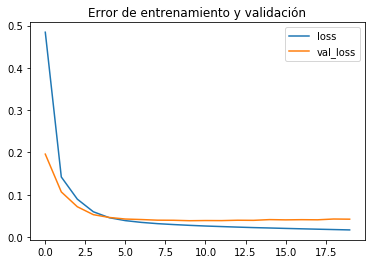

In [40]:
all_f1_score = [[32, error_32]]
for embedding_vector in [16, 64]:
    print('Probando embedding tamaño', embedding_vector)
    hist, model = build_model(embedding_vector)
    _ = pd.DataFrame(data={'loss': hist.history['loss'],
                           'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
    pyplot.show()
    all_f1_score.append([embedding_vector, medir_model(model, X_val, y_val)])

Vemos que el sobreajuste ocurre de manera relativamente similar, y que los tiempos de entrenamiento crecen al aumentar la cantidad de parámetros del embedding.

In [41]:
all_f1_score = np.array(all_f1_score)
_ = pd.Series(all_f1_score[:, 1], index=sorted(all_f1_score[:, 0])).plot(
    title='F1 score según tamaño de embedding')

En este gráfico vemos cómo varió el score en el conjunto de validación para los tres valores experimentados (16, 32 y 64). En conclusión, no hay una relación simple entre tamaño del embedding y score. Puede ocurrir que un tamaño menor (16) como un tamaño mayor (64) obtengan mejor score. En este caso, el mejor score se obtuvo con un embedding de tamaño 64.

> h) Use *Dropout* para entrenar la LSTM. **¿El *Dropout* mejora el desempeño de la red?** Señale cuáles podrı́an ser las causas del comportamiento observado.

No usaremos recurrent_dropout, pues eso crea una máscara diferente de dropout en cada paso de la red recurrente. Esto, según vimos en clases, es equivocado, ya que la misma máscara de dropout debería ser aplicada en todos los pasos de la red recurrente. Nos centraremos en la aplicación de dropout en las otras conexiones de la red. Por un lado, probaremos dropout antes de la capa de salida, y luego agregando también dropout en la capa de entrada.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_4 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 51s 2ms/step - loss: 0.5323 - val_loss: 0.2332
Epoch 2/20
30771/30771 [==============================] - 49s 2ms/step - loss: 0.1925 - val_loss: 0.1386
Epoch 3/2

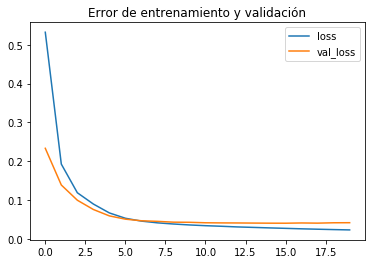

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
dropout_2 (Dropout)          (None, 81, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 81, 100)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 50s 2ms/step - loss: 0.5366 -

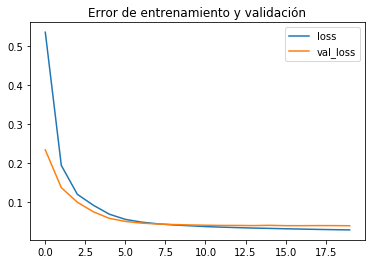

El score de clasificación fue:
Modelo embedding 32: 0.9560514508627678
Modelo embedding 32 con dropout en la salida: 0.9553187995734437
Modelo embedding 32 con dropout en la salida y en la entrada: 0.955818681327297


In [42]:
hist, model = build_model(32, dropout_out=0.2)
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()
error_32_out = medir_model(model, X_val, y_val)
hist, model = build_model(32, dropout_in=0.2, dropout_out=0.2)
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()
error_32_in_out = medir_model(model, X_val, y_val)

print('El score de clasificación fue:')
print('Modelo embedding 32:', error_32)
print('Modelo embedding 32 con dropout en la salida:', error_32_out)
print('Modelo embedding 32 con dropout en la salida y en la entrada:', error_32_in_out)

En ambos casos, el uso de dropout permitió a las redes no sufrir un sobreajuste tan grande, como vemos en los gráficos de pérdida vs. epochs. Lamentablemente, cuando vemos el score de clasificación en el conjunto de validación, vemos que en ambos casos se obtuvo uno menor. Esto significa que el uso de dropout no nos ayudó a mejorar el modelo para este problema.

> i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

Probaremos la red bidireccional a continuación. Según nuestro punto de vista, lo mejor debería ser usar concatenación de la salida de ambas redes. Así, el modelo de clasificación posterior contará con más información para decidir la etiqueta de la palabra considerada. Si se usa media o suma, el modelo estará mezclando la salida de las dos recurrencias. De manera de probar esto, experimentamos la red bidireccional usando concatenación y usando media, y comparamos ambos casos.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 200)           106400    
_________________________________________________________________
dense_6 (Dense)              (None, 81, 18)            3618      
Total params: 757,826
Trainable params: 757,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 97s 3ms/step - loss: 0.4148 - val_loss: 0.2080
Epoch 2/20
30771/30771 [==============================] - 88s 3ms/step - loss: 0.1736 - val_loss: 0.1188
Epoch 3/20
30771/30771 [==============================] - 87s 3ms/step - loss: 0.0983 - val_loss: 0.0811
Epoch 4/20
30771/30771 [============

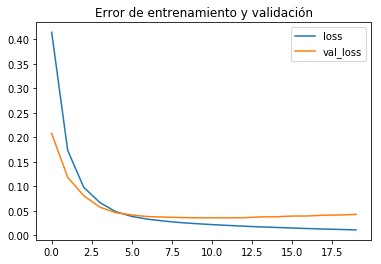

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 81, 100)           106400    
_________________________________________________________________
dense_7 (Dense)              (None, 81, 18)            1818      
Total params: 756,026
Trainable params: 756,026
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 93s 3ms/step - loss: 0.4497 - val_loss: 0.2164
Epoch 2/20
30771/30771 [==============================] - 81s 3ms/step - loss: 0.2044 - val_loss: 0.1861
Epoch 3/20
30771/30771 [==============================] - 90s 3ms/step - loss: 0.1474 - val_loss: 0.1129
Epoch 4/20
30771/30771 [============

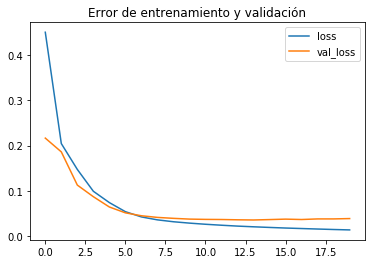

El score de clasificación fue:
Modelo embedding 32 unidireccional: 0.9560514508627678
Modelo embedding 32 bidireccional concat: 0.9627282129952048
Modelo embedding 32 bidireccional ave: 0.9623786381799594


/home/cserpell/git/inf477/tarea3/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
hist, model = build_model(32, bidirectional='concat')
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()
error_32_concat = medir_model(model, X_val, y_val)
hist, model = build_model(32, bidirectional='ave')
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()
error_32_ave = medir_model(model, X_val, y_val)

print('El score de clasificación fue:')
print('Modelo embedding 32 unidireccional:', error_32)
print('Modelo embedding 32 bidireccional concat:', error_32_concat)
print('Modelo embedding 32 bidireccional ave:', error_32_ave)

Tal como esperábamos, la red bidireccional mejoró el desempeño de clasificación en el conjunto de validación. Más aun, la concatenación de la salida recurrente obtuvo aun mejores resultados. Esto está de acuerdo con lo que esperábamos. En cuanto al tiempo de ejecución, las redes bidireccionales resultan más lentas de entrenar, lo que es esperado debido a que la red tiene pasar la secuencia en ambos sentidos cada vez.

> j) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. **Entrene la red definida en f) y compare al utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el *default* de la capa *embedding***, comente sobre las curvas de entrenamiento y los tiempos de entrenamiento.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_8 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_8 (Dense)              (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 63s 2ms/step - loss: 0.8860 - val_loss: 0.4585
Epoch 2/20
30771/30771 [==============================] - 61s 2ms/step - loss: 0.3937 - val_loss: 0.3502
Epoch 3/20
30771/30771 [==============================] - 61s 2ms/step - loss: 0.3137 - val_loss: 0.2715
Epoch 4/20
30771/30771 [============

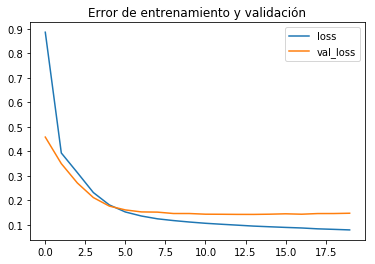

El score de clasificación fue:
Modelo embedding 32: 0.9560514508627678
Modelo embedding 32 mask zero: 0.9560822203549961


In [44]:
hist, model = build_model(32, use_mask_zero=True)
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()
error_32_mask_zero = medir_model(model, X_val, y_val)

print('El score de clasificación fue:')
print('Modelo embedding 32:', error_32)
print('Modelo embedding 32 mask zero:', error_32_mask_zero)

Al utilizar la máscara de valores cero, vemos que el descenso del error durante el entrenamiento, tanto de validación como de entrenamiento, es más lento que en el caso de no utilizar esta característica. Además, los tiempos de ejecución de cada epoch aumentaron, de alrededor de 45 segundos, a 60 segundos. La red comenzó a sobreajustar, al igual que anteriormente, luego de unos 7 epochs. Por otro lado, el score de clasificación fue prácticamente el mismo (la mejora es muy poco significativa).

Si bien pensábamos que esta característica mejoraría el desempeño, ya que no considera las palabras de *padding* que no nos interesa clasificar, en la práctica resultó más lento (tal vez aplicar el filtro de ceros es más lento), y no mejoró el desempeño realmente.

> k) En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras.

Experimentamos dos parámetros que a priori pensábamos que podrían afectar el desempeño del modelo: la cantidad de unidades en la capa recurrente, y el tipo de capa (LSTM o GRU). En todas las pruebas se midió el score sobre el conjunto de validación, y no de test.

Probando LSTM tamaño 50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_9 (LSTM)                (None, 81, 50)            16600     
_________________________________________________________________
dense_9 (Dense)              (None, 81, 18)            918       
Total params: 665,326
Trainable params: 665,326
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 31s 998us/step - loss: 0.6430 - val_loss: 0.2276
Epoch 2/20
30771/30771 [==============================] - 29s 934us/step - loss: 0.1824 - val_loss: 0.1401
Epoch 3/20
30771/30771 [==============================] - 28s 924us/step - loss: 0.1237 - val_loss: 0.1088
Epoch 

Probando LSTM tamaño 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
lstm_10 (LSTM)               (None, 81, 100)           53200     
_________________________________________________________________
dense_10 (Dense)             (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 49s 2ms/step - loss: 0.5331 - val_loss: 0.2261
Epoch 2/20
30771/30771 [==============================] - 47s 2ms/step - loss: 0.1820 - val_loss: 0.1323
Epoch 3/20
30771/30771 [==============================] - 46s 2ms/step - loss: 0.1139 - val_loss: 0.0985
Epoch 4/20


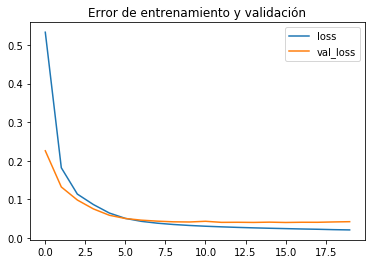

Probando LSTM tamaño 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
lstm_11 (LSTM)               (None, 81, 200)           186400    
_________________________________________________________________
dense_11 (Dense)             (None, 81, 18)            3618      
Total params: 837,826
Trainable params: 837,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 115s 4ms/step - loss: 0.4565 - val_loss: 0.2123
Epoch 2/20
30771/30771 [==============================] - 114s 4ms/step - loss: 0.1539 - val_loss: 0.1069
Epoch 3/20
30771/30771 [==============================] - 112s 4ms/step - loss: 0.0898 - val_loss: 0.0730
Epoch 4/

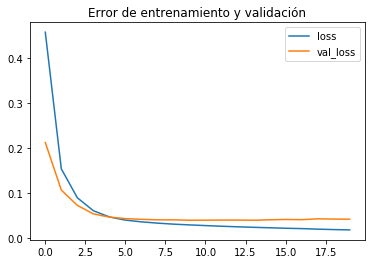

In [45]:
all_f1_score_lstm = []
for recurrent_nodes in [50, 100, 200]:
    print('Probando LSTM tamaño', recurrent_nodes)
    hist, model = build_model(32, recurrent_nodes=recurrent_nodes)
    _ = pd.DataFrame(data={'loss': hist.history['loss'],
                           'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
    pyplot.show()
    all_f1_score_lstm.append([recurrent_nodes, medir_model(model, X_val, y_val)])

Probando LSTM tamaño 50
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
gru_1 (GRU)                  (None, 81, 50)            12450     
_________________________________________________________________
dense_12 (Dense)             (None, 81, 18)            918       
Total params: 661,176
Trainable params: 661,176
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 29s 931us/step - loss: 0.6120 - val_loss: 0.1633
Epoch 2/20
30771/30771 [==============================] - 26s 841us/step - loss: 0.1303 - val_loss: 0.1068
Epoch 3/20
30771/30771 [==============================] - 26s 840us/step - loss: 0.0905 - val_loss: 0.0749
Epoch 

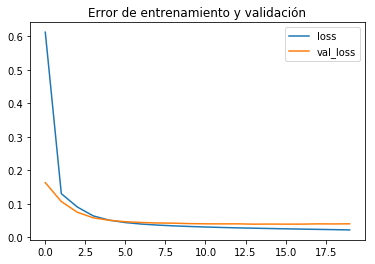

Probando LSTM tamaño 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
gru_2 (GRU)                  (None, 81, 100)           39900     
_________________________________________________________________
dense_13 (Dense)             (None, 81, 18)            1818      
Total params: 689,526
Trainable params: 689,526
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 44s 1ms/step - loss: 0.5186 - val_loss: 0.1735
Epoch 2/20
30771/30771 [==============================] - 42s 1ms/step - loss: 0.1300 - val_loss: 0.1016
Epoch 3/20
30771/30771 [==============================] - 41s 1ms/step - loss: 0.0844 - val_loss: 0.0701
Epoch 4/20


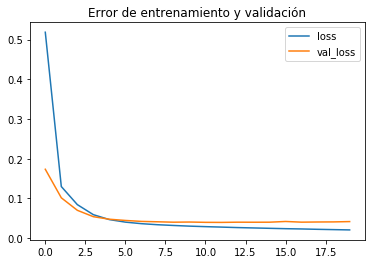

Probando LSTM tamaño 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
gru_3 (GRU)                  (None, 81, 200)           139800    
_________________________________________________________________
dense_14 (Dense)             (None, 81, 18)            3618      
Total params: 791,226
Trainable params: 791,226
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 98s 3ms/step - loss: 0.4489 - val_loss: 0.1589
Epoch 2/20
30771/30771 [==============================] - 93s 3ms/step - loss: 0.1146 - val_loss: 0.0871
Epoch 3/20
30771/30771 [==============================] - 83s 3ms/step - loss: 0.0734 - val_loss: 0.0628
Epoch 4/20


In [46]:
all_f1_score_gru = []
for recurrent_nodes in [50, 100, 200]:
    print('Probando LSTM tamaño', recurrent_nodes)
    hist, model = build_model(32, recurrent_nodes=recurrent_nodes, use_gru=True)
    _ = pd.DataFrame(data={'loss': hist.history['loss'],
                           'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
    pyplot.show()
    all_f1_score_gru.append([recurrent_nodes, medir_model(model, X_val, y_val)])

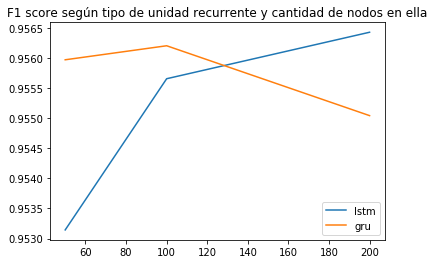

In [47]:
alstm = np.array(all_f1_score_lstm)
agru = np.array(all_f1_score_gru)
_ = pd.DataFrame(data={'lstm': alstm[:, 1], 'gru': agru[:, 1]}, index=sorted(alstm[:, 0])).plot(
    title='F1 score según tipo de unidad recurrente y cantidad de nodos en ella')

En este último gráfico vemos que, en el caso de las LSTM, el score aumenta al aumentar la cantidad de nodos recurrentes, mientras que para las GRU, el máximo se obtiene al usar 100 nodos. Esto significa que la arquitectura de la capa recurrente sí tiene un efecto en el desempeño de los modelos, y no solo el tamaño. De hecho, al usar 200 nodos, vemos que existe una mayor diferencia entre los scores obtenidos usando GRU y LSTM, por lo que la elección de la arquitectura puede ser importante. De todas maneras, la diferencia en el score en todos los casos es muy pequeña, ya que la escala vertical del gráfico va desde 95,30% a 95,65%. El mejor modelo obtenido fue usando LSTM con 200 nodos.

> l) Utilice la red entranda anteriormente, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.

Como hemos perdido la variable con el modelo, volvemos a entrenarlo aquí.

In [48]:
hist, model = build_model(32, recurrent_nodes=200)
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
lstm_12 (LSTM)               (None, 81, 200)           186400    
_________________________________________________________________
dense_15 (Dense)             (None, 81, 18)            3618      
Total params: 837,826
Trainable params: 837,826
Non-trainable params: 0
_________________________________________________________________
Train on 30771 samples, validate on 7693 samples
Epoch 1/20
30771/30771 [==============================] - 112s 4ms/step - loss: 0.4643 - val_loss: 0.2148
Epoch 2/20
30771/30771 [==============================] - 111s 4ms/step - loss: 0.1564 - val_loss: 0.1098
Epoch 3/20
30771/30771 [==============================] - 110s 4ms/step - loss: 0.0953 - val_loss: 0.0803
Epoch 4/20
30771/30771 [=========

A continuación entonces, como ya lo hemos escogido como el mejor modelo, lo probaremos sobre el conjunto de test (ya no el de validación):

In [49]:
print('Error en conjunto de TEST:', medir_model(model, X_test, y_test))

Error en conjunto de TEST: 0.9568848321163621


El score de test obtenido por este mejor modelo es 95,69% muy similar al score obtenido en el conjunto de validación (95,65%), lo que significa que el conjunto de validación era bien representativo del conjunto de test. Es un score bastante alto, y a continuación veremos cómo se comporta en 5 secuencias de ejemplo:

In [50]:
examples = np.random.randint(0, len(X_test), 5)
for example in examples:
    print('===== SEQUENCE NUMBER {} ====='.format(example))
    p = model.predict(np.array([X_test[example]]))
    p = np.argmax(p, axis=-1)
    print('{:15}: {}'.format('Lemma', 'Pred'))
    for w, pred in zip(X_test[example], p[0]):
        print('{:15}: {}'.format(lemmas[w - 1] if w != 0 else '',
                                 labels[pred - 1] if pred != 0 else 'END'))

===== SEQUENCE NUMBER 2796 =====
Lemma          : Pred
the            : O
paper          : O
say            : O
the            : O
expans         : O
plan           : O
is             : O
still          : O
subject        : O
to             : O
govern         : O
approv         : O
,              : O
but            : O
if             : O
adopt          : O
it             : O
call           : O
for            : O
three          : O
line           : O
to             : O
be             : O
complet        : O
in             : O
time           : O
for            : O
the            : O
2008           : B-tim
olymp          : O
.              : O
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               : END
               :

En la primera secuencia, vemos que identificó correctamente *2008* como un tiempo, mientras que en la segunda secuencia no identificó ningún elemento particular. En la tercera, identificó correctamente el gentilicio *iranian*. En la cuarta, identificó dos tipos de objetos correctamente: *israel* como lugar, y *palestinian* como gentilicio. En la última secuencia, identificó *sinc* como tiempo, lo cual, aunque tiene sentido, es una palabra común, por lo que no debería haberla clasificado. Luebo *septemb* como tiempo, lo cual es correcto, y *north korea* como lugar, lo cual también es correcto.

El modelo se comporta bien en general, y está marcando las palabras que tiene que marcar. Incluso, marca correctamente los inicios y continuaciones `B-` e `I-`. Tal vez puede equivocarse en el tipo de palabra (*geo*, *gpe*, *tim*, etc.). Al ser pocas las palabras etiquetadas como no `O`, en comparación con el total, probablemente el modelo se ajusta más para clasificar bien las palabras etiquetadas como `O`, cometiendo más errores en las demás palabras.

En conclusión, el modelo comete errores aun con un score alto. El score alto puede deberse a cómo lo medimos en nuestro caso. Es importante notar que aun si cambiásemos la función de score para considerar las clases no balanceadas, **los modelos habrían sido los mismos**, ya que no se cambiaría la función de pérdida del entrenamiento. Si quisiéramos mejorar eso, tendríamos que utilizar, en vez de *categorial crossentropy*, alguna función de pérdida que considerase más el imbalance de clases.

Ahora utilizaremos el mismo dataset para realizar una aplicación más conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que utilizaremos es del tipo *many to one*.  
Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, **trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores**.

> m) **Carge las palabras del dataset** ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). **Utilice el tamaño del *corpus* que le acomode a la memoria de su computador**.

Usaremos las palabras directamente, pues lo que queremos es generar texto que tenga sentido, y no palabras lemmatizadas que no son naturales de leer. Utilizamos un corpus de tamaño 10% del total. Decidimos usar secuencias de largo 40. Es decir, cada vez que se genere un caracter, la red tendrá el contexto de los últimos 40 caracteres como entrada. Además, cada frase será generada cortando el texto completo a cada 10 caracteres. Esto lo hacemos así, pues, si bien podríamos generar más secuencias cortando cada menos pasos, éstas tendrían mucho traslape, obteniendo menos diversidad.

In [51]:
dataset2 = df_ner.loc[:, ['word', 'lemma']]
text = ' '.join(dataset2['word']).lower()  # corpus
null_character = '*'
chars = [null_character] + sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40  # cut the text in semi-redundant sequences of maxlen characters
step = 10 
sentences = []
next_chars = []
print('Largo total del corpus:', len(text))
size = int(len(text) * 0.1)  # solo un 20% del corpus
print('Largo utilizado:', size)
for i in range(0, size - maxlen, step):
    sentences.append(null_character + text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('numero de  sequences:', len(sentences))
print('Ejemplos:')
print(sentences[:5])
print(next_chars[:5])
print('Lista de caracteres:', chars)

total chars: 72
Largo total del corpus: 6067512
Largo utilizado: 606751
numero de  sequences: 60672
Ejemplos:
['*thousands of demonstrators have marched ', '*of demonstrators have marched through lo', '*rators have marched through london to pr', '*e marched through london to protest the ', '*through london to protest the war in ira']
['t', 'n', 'o', 'w', 'q']
Lista de caracteres: ['*', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\xa0', '°', 'é', 'ë', 'ö', 'ü', '–', '—', '’', '“', '”', '…']


Vemos entonces que en los textos hay 72 caracteres posibles, listados al final. Tenemos entonces 60.672 secuencias, y se muestran unos pocos ejemplos. Cada secuencia la comenzamos por un caracter especial que indica el comienzo.

> n) **Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres**, tal cual se realizó en c) con los *lemmas*, **lo mismo para las etiquetas**. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo significará que no hay información. **Transforme las etiquetas a *one hot vector*** como se realizó en c) y **defina la red** similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA)[[2]](#refs) para *Deep Neural Network*. 

Al igual que en la primera parte de esta pregunta, creamos un dataset donde los caracteres están codificados con números enteros, y la salida está codificada como vectores *one hot*. Podemos notar que la salida, al ser solo un caracter, es de dimensión 72, sin otra dimensión adicional. Además, creamos conjuntos de entrenamiento, validación y prueba. Estos dos últimos tienen tamaño 5 mil.

In [52]:
datacharX = np.array([[char_indices[char] for char in sentence] for sentence in sentences])
datacharY = [char_indices[char] for char in next_chars]
n_chars = len(char_indices)
# dataX pad sequence padding='pre'
# dataY to categorical with num_classes=len(chars)
ychar_one_hot = np.asarray([utils.to_categorical(i, num_classes=n_chars) for i in datacharY])

Xchar_train_val, Xchar_test, ychar_train_val, ychar_test = model_selection.train_test_split(
    datacharX, ychar_one_hot, test_size=0.0824)  # , random_state=22)
Xchar_train, Xchar_val, ychar_train, ychar_val = model_selection.train_test_split(
    Xchar_train_val, ychar_train_val, test_size=0.0898)
print('Tamaño X train:', Xchar_train.shape, 'y train:', ychar_train.shape)
print('Tamaño X val:', Xchar_val.shape, 'y val:', ychar_val.shape)
print('Tamaño X test:', Xchar_test.shape, 'y test:', ychar_test.shape)

Tamaño X train: (50672, 41) y train: (50672, 72)
Tamaño X val: (5000, 41) y val: (5000, 72)
Tamaño X test: (5000, 41) y test: (5000, 72)


Lamentablemente, no pudimos usar la capa CuDNNGRU en nuestro caso, pues no teníamos GPU en donde corrimos esta pregunta, pero usaremos una GRU tradicional.

>  o) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente **¿Cuál es la técnica para predecir el siguiente carácter?**

Creamos funciones auxiliares que crean secuencias a partir del modelo actual:

In [53]:
def predict_next_char(model, sentence, determinist=False):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]] + [char_indices[char] for char in sentence]
    # x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen + 1, padding='pre',
    #                                 value=char_indices[null_character])
    preds = model.predict(np.array(x_pred).reshape((1, maxlen + 1)), verbose=0)[0]
    if determinist:
        next_index = np.argmax(preds)
    else:
        next_index = np.random.choice(n_chars, p=preds)  # take a sample
    return indices_char[next_index]


def run_sentence(model, sentence, determinist=False):
    print('----- Generating with seed: "{}"'.format(sentence))
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence, determinist=determinist)
        sentence = sentence[1:] + next_char  # for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()

Aquí creamos el modelo, similar al resto de la pregunta, con una capa de embedding, y dropout en la salida.

In [54]:
EPOCHS = 20

def build_model(embedding_vector, recurrent_nodes=512, epochs=EPOCHS):
    model = models.Sequential()

    def on_epoch_end(epoch, logs):
        """Function invoked at end of each epoch. Prints generated text."""
        print('\n----- Generating text after Epoch:', epoch)
        start_index = random.randint(0, size - maxlen - 1)
        sentence = text[start_index:start_index + maxlen]
        run_sentence(model, sentence)

    model.add(layers.Embedding(input_dim=n_chars,
                               output_dim=embedding_vector,
                               input_length=(maxlen + 1)))
    # model.add(layers.CuDNNGRU(units=recurrent_nodes, return_sequences=False))
    model.add(layers.GRU(units=recurrent_nodes, return_sequences=False))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(n_chars, activation=activations.softmax))
    model.summary()
    model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(),
                  metrics=['accuracy'])
    print_callback = callbacks.LambdaCallback(on_epoch_end=on_epoch_end)
    hist = model.fit(Xchar_train, ychar_train, validation_data=(Xchar_val, ychar_val),
                     epochs=epochs,
                     batch_size=512, callbacks=[print_callback])
    return hist, model

Entrenamos el modelo entonces, con un embedding de tamaño 32 y 512 nodos recurrentes.

In [55]:
hist, model = build_model(16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 41, 16)            1152      
_________________________________________________________________
gru_4 (GRU)                  (None, 512)               812544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 72)                36936     
Total params: 850,632
Trainable params: 850,632
Non-trainable params: 0
_________________________________________________________________
Train on 50672 samples, validate on 5000 samples
Epoch 1/20
50672/50672 [==============================] - 239s 5ms/step - loss: 3.0976 - acc: 0.1640 - val_loss: 2.9092 - val_acc: 0.1706

----- Generating text after Epoch: 0
----- Generating with seed: "ed flawed by m

ce of seeking to spark a civil war in least said bo karnsa io pelpenis neatherili wid tres lrot sand the inreedoni narion themes elvo naald 's porsimind are grish yerd af aisty ateadsh nepeelciouss berauke sey ith sextite wowef reage es-deysside quad the eer-gani and upfoy the pland anthurlit hay contracemys in oopeast al ouf . " shear astsbenced povimet aivert vancualy seaft , wo suncouss and to pare framad binistan abtions tionsurd kiEpoch 12/20
50672/50672 [==============================] - 236s 5ms/step - loss: 1.7152 - acc: 0.4905 - val_loss: 1.8701 - val_acc: 0.4626

----- Generating text after Epoch: 11
----- Generating with seed: "mportance of opium cultivation to afghan"
mportance of opium cultivation to afghancing tobiflew the counts of the porati made recioksung the covur hes crusisal conmonmant palettonn cornerg , enich fromsthect a trebing provikon ot a solfiming for talmse winl weln southonit silingria , iarjizod kiolming " the iantes a rece troops to ,000 , iral , itrapb

Podemos ver a lo largo del entrenamiento, cómo la secuencia generada va cobrando más sentido. Comienzan gradualmente a aparecer palabras más parecidas al inglés, incluso con puntuación. Lamentablemente, como la generación es caracter a caracter, muchas veces hay caracteres que hacen que las palabras no tengan sentido. La frase complete, por lo general, no tiene ningún sentido, y esto puede deberse a la pérdida del contexto del texto completo, junto con falta de mayor entrenamiento, tanto por el tamaño del conjunto de entrenamiento, como por la cantidad de epochs y falta de regularización.

A continuación vemos que gran parte del problema puede venir dado por el sobreajuste del modelo: Luego de unos 15 epochs, el modelo comenzó a sobreajustar seriamente, obteniendo un error de validación creciente.

In [56]:
_ = pd.DataFrame(data={'loss': hist.history['loss'],
                       'val_loss': hist.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()

Luego de ver este gráfico, podemos volver a las secuencias generadas durante el entrenamiento y revisar la del epoch 15:

Generating with seed: "ral square in the city after clearing ou"

"ral square in the city after clearing outerel medees acliem to haid refiestallot the elinger joumh of the statt around duclamed the uring reed at pxkied watar seidth ufety scoul millt laune ob motustan the proor mand ceperated at the iorted envilcudes aro68 jaonetition forengs in southers toxnoust kentery ale esings the union of at thes year  . comnet ot shafitil hyveel decyions proers is gopredt nergy o, caopaing pericled madts a bet g".

Aun así, no tiene mucho sentido.

> p) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. **Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.**

In [57]:
sentence = 'this is a sample sentence that is so fun'
# 40 chars: 1234567890123456789012345678901234567890
print('Secuencia no determinista:')
run_sentence(model, sentence)
print('\nSecuencia no determinista:')
run_sentence(model, sentence)
print('\nSecuencia determinista:')
run_sentence(model, sentence, determinist=True)
print('\n\n===================OTRA==================')
sentence = 'federico saint mary technical university'
# 40 chars: 1234567890123456789012345678901234567890
print('Secuencia no determinista:')
run_sentence(model, sentence)
print('\nSecuencia no determinista:')
run_sentence(model, sentence)
print('\nSecuencia determinista:')
run_sentence(model, sentence, determinist=True)

Secuencia no determinista:
----- Generating with seed: "this is a sample sentence that is so fun"
this is a sample sentence that is so funding vote of challez0on cramss scact herd went in the uptarded has ratt ag pefpes in a prace . the ronsowt . veresson outsurked a be-wer . it . cozleen thar owhs say ghon hashan, were fired . gureting says it hive been list ween of conter , itaqi soldinist and wercer 's elice ig isroulimged in musan military in sile bet to tryent in notes in loince . wernmile for the coalt as the collanse resions 
Secuencia no determinista:
----- Generating with seed: "this is a sample sentence that is so fun"
this is a sample sentence that is so fundid hombithes wo expra pelicale . itwal 's tlial cemarrat . mr. a mrmmay deroch cransed questhy months ag exricmed stutks " the ower to krapigute rover meotersuanole then and were canduring scilihing to deso mincroug the u.n. election .s officials say trein aly attom hrowing a rusionsia commined tho incesedon in curing af

Podemos ver que la generación no determinista consigue distintos textos cada vez que es ejecutada. Generalmente, en la generación determinista lo que ocurre es que se llega a un ciclo de caracteres que comienza a repetirse indefinidamente, aunque parecen tener más calidad en las palabras generadas. Esto ocurre pues, como vamos alimentando la red con la salida generada por ella misma, ya no tiene "ruido" ni datos para salir de la secuencia que se repite.

Como antes vimos que la red sobreajustó desde el epoch 15, volveremos a entrenar la red usando solo 15 epochs:

In [58]:
hist2, model2 = build_model(16, epochs=15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 41, 16)            1152      
_________________________________________________________________
gru_5 (GRU)                  (None, 512)               812544    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 72)                36936     
Total params: 850,632
Trainable params: 850,632
Non-trainable params: 0
_________________________________________________________________
Train on 50672 samples, validate on 5000 samples
Epoch 1/15
50672/50672 [==============================] - 237s 5ms/step - loss: 3.4419 - acc: 0.1394 - val_loss: 2.9344 - val_acc: 0.1706

----- Generating text after Epoch: 0
----- Generating with seed: " return home ,

h . analysts say the department of labornt bretes sean nas " the foul billen u.temd to loj0 saulbel heopreat hacian lembibh atsacker tiel inth a " on shand toncest as exonent polled at bomth hark an -homl lunded , thit thire sinuns prognmant now been a nom the illicked n. devennmase a. to ko fored krila bot cantons id ares the stoul propest a mert h officat rerouteresess fulshing wish gir the sers preses . amding prove blitg a souten suEpoch 12/15
50672/50672 [==============================] - 237s 5ms/step - loss: 1.9151 - acc: 0.4311 - val_loss: 1.9636 - val_acc: 0.4276

----- Generating text after Epoch: 11
----- Generating with seed: "isited the italian city of l'aquilla and"
isited the italian city of l'aquilla and the ureqt is a cuting work $ boks fer the unies hext sompo wall wor  korution ou hithono on qasious -and dudlakte 106 . a furles meded for seodel in the prored kindan prusid . irali anainged never masel my.d the amin moficman ingo the couptiteming oled , a lose terndry 

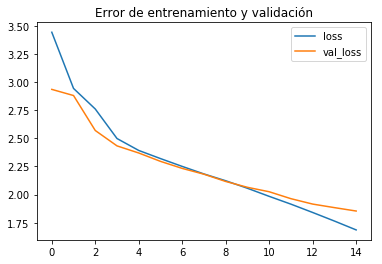

In [59]:
_ = pd.DataFrame(data={'loss': hist2.history['loss'],
                       'val_loss': hist2.history['val_loss']}).plot(title='Error de entrenamiento y validación')
pyplot.show()

Vemos que en este caso efectivamente ya no sobreajustamos, obteniendo un modelo mejor en su capacidad de generalización, que experimentaremos a continuación:

In [60]:
sentence = 'this is a sample sentence that is so fun'
# 40 chars: 1234567890123456789012345678901234567890
print('Secuencia no determinista:')
run_sentence(model2, sentence)
print('\nSecuencia no determinista:')
run_sentence(model2, sentence)
print('\nSecuencia determinista:')
run_sentence(model2, sentence, determinist=True)
print('\n\n===================OTRA==================')
sentence = 'federico saint mary technical university'
# 40 chars: 1234567890123456789012345678901234567890
print('Secuencia no determinista:')
run_sentence(model2, sentence)
print('\nSecuencia no determinista:')
run_sentence(model2, sentence)
print('\nSecuencia determinista:')
run_sentence(model2, sentence, determinist=True)

Secuencia no determinista:
----- Generating with seed: "this is a sample sentence that is so fun"
this is a sample sentence that is so fundings . nows wele retions astre chuslin-torews and atg is nethert daccors bedanes tho brigo . voo cellened nomingt netaral unterved porty a fithrical years ares in siren has chitenels weverom the 50 in noms and bith a group he lids ) menibal porber sand the arirgs . birtore says soun has dreteves on itries ar prasines , and affichur didisten thear alon farm countrdem 's reaitod vicitat it diverrle
Secuencia no determinista:
----- Generating with seed: "this is a sample sentence that is so fun"
this is a sample sentence that is so functh tole crapitirn frum jyeh in the cotted ig disint pligedenc milligst sead in nepaland stoms an inengern cobloath reneled encore mincanistor repsome in 1928 's rateora day hillels . chaign that the neponts of burident thao wiiled that to ghe aurl-ans say thes –rpoustin till thot of then the chayse coores 's soribam , as

En la secuencias generadas, vemos que, si bien en la métrica esta red debería funcionar mejor, de todas maneras al generar de manera no determinista, los textos generados poseen muchos errores de escritura. Muchas de las palabras generadas no tienen sentido. Con respecto a la generación determinista, ahora sí vemos claramente el comportamiento de secuencia que se repite indefinidamente.

En conclusión a esta pregunta, podemos listar los aprendizajes más importantes:
- Las redes recurrentes consiguen modelar el comportamiento de secuencias, en este caso de texto.
- Es importante definir bien las métricas para error y score, pues eso determina las elecciones de modelo a usar, y cómo entrenar la red. Una elección equivocada puede invalidar todos los resultados.
- Es importante considerar el problema de sobreajuste, incluso en redes recurrentes que tienen menos parámetros que redes feedforward.
- Algunas veces, arquitecturas más complejas y opciones como dropout, que podrían parecer siempre necesarias, no lo son, como resultó en el caso de estas redes recurrentes.
- Al generar datos, por ejemplo caracteres en este caso, es importante agregar aleatoriedad, para no tener un modelo que no es capaz de generar con diversidad.

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html